# ECG Project: Automated Data Preprocessing, Model Training, and Evaluation

This notebook automates the entire process for working with ECG data:
1. Create directories for datasets, models, and reports.
2. Download the MIT-BIH Arrhythmia dataset using `curl`.
3. Preprocess the data, train an LSTM model, and generate results.

## 1. Install Libraries
Ensure necessary libraries are installed:

In [1]:
# Install required libraries
!pip install wfdb biosppy numpy pandas matplotlib tensorflow scikit-learn fpdf

^C


## 2. Set Up Directory Structure and Download Data
Let's automatically create directories and use `curl` to download the MIT-BIH Arrhythmia dataset.

In [2]:
import os

# Create directory structure
os.makedirs('./dataset', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./reports', exist_ok=True)

# Download MIT-BIH data using curl (ensure curl is installed)
dataset_url = 'https://physionet.org/files/mitdb/1.0.0/100.dat'
os.system(f'curl -o ./dataset/100.dat {dataset_url}')
os.system('curl -o ./dataset/100.hea https://physionet.org/files/mitdb/1.0.0/100.hea')
os.system('curl -o ./dataset/100.atr https://physionet.org/files/mitdb/1.0.0/100.atr')

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 2.8 MB/s eta 0:00:04
   --- ------------------------------------ 1.0/11.0 MB 3.0 MB/s eta 0:00:04
   ------ --------------------------------- 1.8/11.0 MB 2.6 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.0 MB 2.6 MB/s eta 0:00:04
   ---------- ----------------------------- 2.9/11.0 MB 2.7 MB/s eta 0:00:04
   ------------- -------------------------- 3.7/11.0 MB 2.8 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/11.0 MB 2.9 MB/s eta 0:00:03
   ------------------ --------------------- 5.0/11.0 MB 3.0 MB/s eta 0:00:03
   -------------------- ------------------- 5.8/11.0 MB 2.9 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.0 MB 3.0 MB/s 

    numpy (>=1.19.*) ; python_version >= "3.7"
           ~~~~~~~^
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sqlalchemy 2.0.34 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
filelock 3.12.3 requires typing-extensions>=4.7.1; python_version < "3.11", but you have typing-extensions 4.5.0 which is incompatible.
langchain-core 0.2.33 requires typing-extensions>=4.7, but you have typing-extensions 4.5.0 which is incompatible.
open-clip-torch 2.20.0 requires protobuf<4, but you have protobuf 4.24.3 which is incompatible.
openai 1.41.1 requires typing-extensions<5,>=4.11, but you have typing-extensions 4.5.0 which is incompatible.
tb-nightly 2.15.0a20230902 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.24.3 which is incompatible.


0

## 3. Load and Explore the ECG Dataset
Now that the data is downloaded, let's load and visualize it.

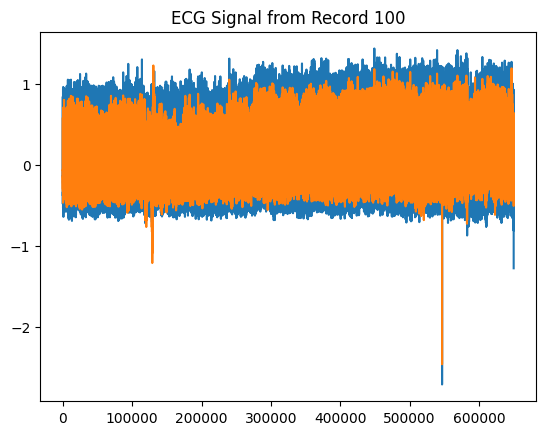

Sampling Frequency: 360 Hz
Signal Shape: (650000, 2)


In [7]:
import wfdb
import matplotlib.pyplot as plt

# Load Record 100 from the MIT-BIH Arrhythmia Database
record = wfdb.rdrecord('dataset/100')
annotation = wfdb.rdann('dataset/100', 'atr')

# Plot the ECG signal
plt.plot(record.p_signal)
plt.title('ECG Signal from Record 100')
plt.show()

# Display basic record details
print(f"Sampling Frequency: {record.fs} Hz")
print(f"Signal Shape: {record.p_signal.shape}")

## 4. Preprocess the Data
We'll extract R-peaks and heart rate using the `biosppy` library.

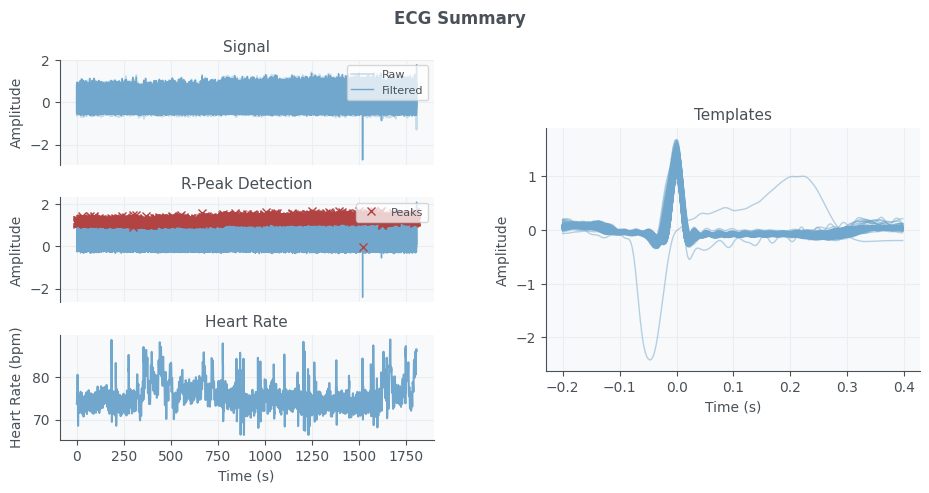

R-peaks: [    77    370    663 ... 649232 649484 649733]
Heart Rate: [73.72013652 74.49887036 75.27760419 ... 86.30564037 85.83354791
 86.40275387]


In [8]:
from biosppy.signals import ecg

# Extract first channel of the ECG signal
signal = record.p_signal[:, 0]

# Process the ECG signal
out = ecg.ecg(signal=signal, sampling_rate=record.fs, show=True)

# Extract and display R-peaks and heart rate
r_peaks = out['rpeaks']
heart_rate = out['heart_rate']

print(f"R-peaks: {r_peaks}")
print(f"Heart Rate: {heart_rate}")

## 5. Prepare Data for LSTM Model Input
Prepare the ECG data in the form of sequences for time-series input to an LSTM model.

In [9]:
import numpy as np

# Set window size for sequence splitting
window_size = 100
X = []

# Create overlapping windows
for i in range(0, len(signal) - window_size, window_size):
    X.append(signal[i:i + window_size])

X = np.array(X)
X = np.expand_dims(X, axis=2)  # Add feature dimension

print(f"Prepared Input Shape: {X.shape}")

Prepared Input Shape: (6499, 100, 1)


## 6. Train the LSTM Model
Create and train an LSTM model on the preprocessed ECG data.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, np.ones(len(X)), test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save the trained model
model.save('./models/model_lstm.h5')

Epoch 1/10
163/163 [==============================] - 40s 213ms/step - loss: 0.0287 - accuracy: 0.9938 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/10
163/163 [==============================] - 32s 194ms/step - loss: 4.1406e-04 - accuracy: 1.0000 - val_loss: 3.4750e-04 - val_accuracy: 1.0000
Epoch 3/10
163/163 [==============================] - 34s 209ms/step - loss: 1.5842e-04 - accuracy: 1.0000 - val_loss: 1.4505e-04 - val_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 26s 161ms/step - loss: 8.0631e-05 - accuracy: 1.0000 - val_loss: 8.1338e-05 - val_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 28s 172ms/step - loss: 5.3174e-05 - accuracy: 1.0000 - val_loss: 5.9200e-05 - val_accuracy: 1.0000
Epoch 6/10
163/163 [==============================] - 30s 184ms/step - loss: 3.8150e-05 - accuracy: 1.0000 - val_loss: 4.4132e-05 - val_accuracy: 1.0000
Epoch 7/10
163/163 [==============================] - 29s 177ms/step - loss: 2.7293e-05 - 

c:\Users\tanis\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. Evaluate the Model
Evaluate the performance of the LSTM model on the test data.

41/41 [==============================] - 3s 65ms/step - loss: 1.5576e-05 - accuracy: 1.0000
Test Loss: 1.5576097212033346e-05
Test Accuracy: 1.0
41/41 [==============================] - 3s 53ms/step


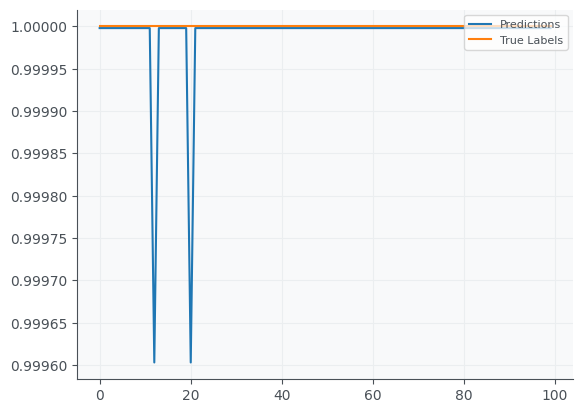

In [11]:
# Evaluate the model
results = model.evaluate(X_test, y_test)
print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")

# Predictions
predictions = model.predict(X_test)

# Plot predictions vs true labels
plt.plot(predictions[:100], label='Predictions')
plt.plot(y_test[:100], label='True Labels')
plt.legend()
plt.show()

## 8. Generate PDF Report
Automatically generate a PDF report with the evaluation results.

In [12]:
from fpdf import FPDF

# Initialize PDF
pdf = FPDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 16)
pdf.cell(200, 10, 'ECG Analysis Report', ln=True, align='C')

# Add results to the PDF
pdf.ln(10)
pdf.set_font('Arial', '', 12)
pdf.cell(200, 10, f'Test Accuracy: {results[1]:.4f}', ln=True)
pdf.cell(200, 10, f'Test Loss: {results[0]:.4f}', ln=True)

# Save the report to the reports folder
pdf.output('./reports/ecg_analysis_report.pdf')

print("Report generated and saved to ./reports/ecg_analysis_report.pdf")

Report generated and saved to ./reports/ecg_analysis_report.pdf
